In [17]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-05 09:20:19.895695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 09:20:20.416596: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 09:20:20.418920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 09:20:22.443887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read agricultural data into pandas df

In [309]:
#Read CSV into dataframe
ag_data = pd.read_csv('Agrofood_co2_emission.csv')

#Format column headers
ag_data.columns = ag_data.columns.str.replace(' -', '')
ag_data.columns = ag_data.columns.str.replace('(', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(')', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(' ', '_')
ag_data.columns = map(str.lower, ag_data.columns)


ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_°c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [254]:
# ag_data.info()
ag_data.shape

(6965, 31)

### Drop Unecessary Columns:
total emissions, rural population, male population, female population

In [310]:
ag_data = ag_data.drop(['total_emission','total_population_female', 'total_population_male', 'rural_population'], axis=1)

In [256]:
# ag_data.info()
ag_data.shape

(6965, 27)

### Combine similar columns:

fires = savanna_fires + forest_fires + fires_in_organic_soils + fires_in_humid_tropical_forests
</br>manure_mgmt = manure_applied_to_soils + manure_left_on_pasture + manure_management
</br>food_systems = food_processing + food_packaging + food_retail + food_transport + food_houshold_consumption + agrifood_systems_waste_disposal
</br>ippu_tot = ippu + pesticides_manufacturing + fertilizers_manufacturing
</br>on_farm_energy_use = on-farm_electricity_use + on-farm_energy_use

In [311]:
ag_data['fires'] = ag_data['savanna_fires']+ag_data['forest_fires']+ag_data['fires_in_organic_soils']+ag_data['fires_in_humid_tropical_forests']
ag_data['manure_mgmt'] = ag_data['manure_applied_to_soils']+ag_data['manure_left_on_pasture']+ag_data['manure_management']
ag_data['food_systems'] = ag_data['food_processing']+ag_data['food_packaging']+ag_data['food_retail']+ag_data['food_transport']+ag_data['food_household_consumption']+ag_data['agrifood_systems_waste_disposal']
ag_data['ippu_tot'] = ag_data['ippu']+ag_data['pesticides_manufacturing']+ag_data['fertilizers_manufacturing']
ag_data['on_farm_energy_use'] = ag_data['on-farm_electricity_use'] + ag_data['on-farm_energy_use']

In [312]:
#Drop individual columns
ag_data = ag_data.drop(['savanna_fires', 'forest_fires', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests',
                       'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'food_processing',
                       'food_packaging', 'food_retail', 'food_transport', 'food_household_consumption',
                       'agrifood_systems_waste_disposal', 'ippu', 'pesticides_manufacturing', 'fertilizers_manufacturing',
                       'on-farm_electricity_use', 'on-farm_energy_use'], axis=1)

In [259]:
# ag_data.info()
ag_data.shape

(6965, 14)

### Read Multivariate ENSO Index (MEI) data into pandas df

In [313]:
enso_data = pd.read_csv('meiv2.csv')
enso_data.columns = map(str.lower, enso_data.columns)

#Drop years before 1990 and after 2020
enso_data = enso_data[enso_data['year'] <= 2020]
enso_data = enso_data[enso_data['year'] > 1989]

enso_data = enso_data.set_index('year')

#Calculate yearly average index
enso_data['mei'] = enso_data.mean(axis=1)

#Reset index
enso_data = enso_data.reset_index(names=['year'])

#Drop months columns
enso_data = enso_data.drop(["dj",'jf','fm','ma','am','mj','jj','ja','as','so','on','nd'], axis='columns')

### Join DFs

In [314]:
ag_data = ag_data.merge(enso_data, left_on='year', right_on='year')

In [262]:
ag_data.head()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
0,Afghanistan,1990,205.6077,686.000000,0.0000,-2388.8030,0.0000,2593947.0,0.536167,14.7794,2169.8513,1263.479256,233.782283,NaN,0.2
1,Albania,1990,59.2391,23.520000,110.5705,72.8581,0.0000,1195379.0,0.735750,12.5814,1054.6462,650.148524,1125.636617,366.090800,0.2
2,Algeria,1990,164.2776,4.312000,0.0000,-111.1403,684.9333,13496502.0,1.005583,144.6946,2758.8447,13250.763265,5288.278000,141.633800,0.2
3,American Samoa,1990,NaN,926.342278,0.0000,-58.8991,7.9612,38076.0,0.566500,0.0000,NaN,199.688951,NaN,58.504263,0.2
4,Andorra,1990,NaN,926.342278,0.0000,0.0000,0.0000,51627.0,1.278500,0.0000,NaN,570.011357,1711.187476,74.704263,0.2


In [263]:
# ag_data.info()
ag_data.shape

(6965, 15)

### Compute rolling totals & Add new columns

In [315]:
def calc_rolling_total(df, column, time_period):
    return (df
            .groupby('area')[column]
            .transform(lambda df: df.rolling(time_period).sum()))

In [316]:
cols = ['crop_residues', 'rice_cultivation', 'drained_organic_soils_co2',
       'net_forest_conversion', 'fires', 'manure_mgmt', 'food_systems',
       'ippu_tot', 'on_farm_energy_use', 'forestland']

In [317]:
for col in cols:
    ag_data['5yr_'+str(col)] = calc_rolling_total(ag_data, col, 5)

In [318]:
for col in cols:
    ag_data['10yr_'+str(col)] = calc_rolling_total(ag_data, col, 10)

In [319]:
for col in cols:
    ag_data['20yr_'+str(col)] = calc_rolling_total(ag_data, col, 20)

In [269]:
ag_data.tail()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,average_temperature_°c,fires,...,20yr_crop_residues,20yr_rice_cultivation,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland
6960,Wallis and Futuna Islands,2020,NaN,4112.742030,0.0000,0.0000,0.0000,0.0,1.232333,0.0000,...,NaN,76096.804360,0.0000,85.6090,0.000000e+00,NaN,NaN,NaN,10990.711434,-72.6645
6961,Western Sahara,2020,NaN,926.342278,0.0000,-104.5657,0.0000,518663.0,2.068000,0.0000,...,NaN,18526.845569,0.0000,409.9035,0.000000e+00,NaN,NaN,NaN,NaN,-4814.5545
6962,Yemen,2020,42.7411,796.196122,0.0000,0.0000,0.0000,11465414.0,1.320126,0.0000,...,1160.2533,13901.882040,0.0000,0.0000,1.869000e-01,55674.2276,143609.988473,42715.266455,37923.032213,0.0000
6963,Zambia,2020,205.7266,48.521800,14566.6658,0.0000,19047.2568,8336381.0,0.714417,54929.7826,...,2581.0404,839.905100,290382.9257,226684.9640,1.105177e+06,39116.5827,45443.238148,28787.794031,1823.799100,0.0000
6964,Zimbabwe,2020,108.3022,7.973300,0.0000,76500.2982,10662.4408,5700460.0,0.189000,530.3224,...,2140.8887,86.071700,0.0000,213443.0780,4.251108e+04,62779.7183,40474.674000,45336.574844,36274.854100,388368.0030


### Reorder Columns

In [320]:
reordered_cols = ['area', 'year', 'urban_population', 'mei', 'crop_residues',
       'rice_cultivation', 'drained_organic_soils_co2',
       'net_forest_conversion', 'fires', 'manure_mgmt', 'food_systems',
       'ippu_tot', 'on_farm_energy_use', 'forestland',
       '5yr_crop_residues', '5yr_rice_cultivation',
       '5yr_drained_organic_soils_co2', '5yr_net_forest_conversion',
       '5yr_fires', '5yr_manure_mgmt', '5yr_food_systems', '5yr_ippu_tot',
       '5yr_on_farm_energy_use', '5yr_forestland', '10yr_crop_residues',
       '10yr_rice_cultivation', '10yr_drained_organic_soils_co2',
       '10yr_net_forest_conversion', '10yr_fires', '10yr_manure_mgmt',
       '10yr_food_systems', '10yr_ippu_tot', '10yr_on_farm_energy_use',
       '10yr_forestland', '20yr_crop_residues', '20yr_rice_cultivation',
       '20yr_drained_organic_soils_co2', '20yr_net_forest_conversion',
       '20yr_fires', '20yr_manure_mgmt', '20yr_food_systems', '20yr_ippu_tot',
       '20yr_on_farm_energy_use', '20yr_forestland', 'average_temperature_°c']
ag_data = ag_data[reordered_cols]

ag_data.head()

,area,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,...,20yr_rice_cultivation,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland,average_temperature_°c
0,Afghanistan,1990,2593947.0,0.2,205.6077,686.000000,0.0000,0.0000,14.7794,2169.8513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536167
1,Albania,1990,1195379.0,0.2,59.2391,23.520000,110.5705,0.0000,12.5814,1054.6462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735750
2,Algeria,1990,13496502.0,0.2,164.2776,4.312000,0.0000,684.9333,144.6946,2758.8447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005583
3,American Samoa,1990,38076.0,0.2,NaN,926.342278,0.0000,7.9612,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.566500
4,Andorra,1990,51627.0,0.2,NaN,926.342278,0.0000,0.0000,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.278500


### Evaluate Countries with fewer than 31 years:

In [363]:
ag_data_area = ag_data.groupby('area').sum()
ag_data_area.loc[ag_data_area['year'] != 62155]

,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,food_systems,...,20yr_rice_cultivation,20yr_drained_organic_soils_co2,20yr_net_forest_conversion,20yr_fires,20yr_manure_mgmt,20yr_food_systems,20yr_ippu_tot,20yr_on_farm_energy_use,20yr_forestland,average_temperature_°c
area,,,,,,,,,,,,,,,,,,,,,
Armenia,58174,5.635726e+07,-2.933333,867.9864,7193.783413,0.000000e+00,2917.1471,147.4283,12704.6754,3.341263e+04,...,49612.299402,0.000000e+00,2.511534e+04,1.021186e+03,8.683991e+04,2.402362e+05,2.341487e+05,4.309982e+04,-9.507903e+03,30.398333
Azerbaijan,58174,1.347994e+08,-2.933333,4224.8868,540.850300,0.000000e+00,4081.8835,869.7217,57311.7177,1.505620e+05,...,3688.180100,0.000000e+00,2.489823e+04,5.946817e+03,4.007650e+05,1.053898e+06,3.589915e+05,3.025475e+05,-4.200900e+05,30.718750
Belarus,58174,2.051809e+08,-2.933333,12870.7709,26863.926076,1.237739e+06,44432.5316,1139.1979,118212.6124,2.316582e+05,...,185268.455694,8.567048e+06,2.749150e+05,7.997382e+03,7.835883e+05,1.578719e+06,2.684695e+06,6.429565e+05,-9.714638e+06,43.376000
Belgium,42210,2.241269e+08,-4.991667,3792.0467,15238.494610,4.233712e+03,13283.4030,1.7183,79432.2159,2.515535e+05,...,29045.246731,8.053790e+03,2.556220e+04,3.144200e+00,1.509388e+05,4.814215e+05,7.779817e+05,9.600227e+04,-1.184382e+05,31.193667
Bosnia and Herzegovina,58174,4.783055e+07,-2.933333,1935.6795,7215.045405,3.432881e+03,0.0000,663.6878,22613.4146,6.318621e+04,...,49781.178583,2.390168e+04,0.000000e+00,4.785739e+03,1.579365e+05,4.498566e+05,3.145279e+05,1.423080e+04,-4.063234e+03,34.322833
Croatia,58174,6.917302e+07,-2.933333,4609.2055,16056.151542,2.582154e+02,8217.6994,358.3903,26695.2161,7.960718e+04,...,110494.201525,1.783300e+03,4.877220e+04,2.370251e+03,1.840568e+05,5.860312e+05,8.951503e+05,1.660167e+05,-2.977776e+05,36.427000
Czechia,56182,2.156180e+08,-4.125000,12395.6109,24001.145653,7.543190e+03,18459.6918,16.0832,47520.7339,3.448612e+05,...,153375.093185,4.830795e+04,1.225554e+05,1.088061e+02,2.950132e+05,2.246829e+06,1.467291e+06,3.822967e+05,-1.338620e+06,38.685250
Eritrea,56182,3.771124e+07,-4.125000,692.5093,6945.721916,2.335284e+02,18955.4495,697.3014,37665.2905,2.222150e+04,...,44651.069462,1.501254e+03,1.217944e+05,4.273769e+03,2.471915e+05,1.340102e+05,1.073229e+05,5.016875e+03,-4.437067e+04,23.028537
Estonia,58174,2.739272e+07,-2.933333,1619.2633,8222.891707,1.405515e+05,0.0000,32.7562,11579.9046,4.629095e+04,...,53853.728461,9.856257e+05,0.000000e+00,2.534685e+02,7.338316e+04,3.216401e+05,1.700494e+05,1.022235e+05,-9.104692e+05,44.152250


### Drop Belgium-Luxembourg

Not sure why Belgium & Luxembourg are reported together between 1990 and 2000, but not sure how to accurately split info for these years into each country. Propose dropping these data points. 

In [326]:
# ag_data[ag_data['area'] == 'Belgium']
# ag_data[ag_data['area'] == 'Luxembourg']
# ag_data[ag_data['area'] == 'Belgium-Luxembourg']

ag_data = ag_data[ag_data['area'] != 'Belgium-Luxembourg']

### Drop Czechoslovakia

Czeochoslovakia split into Czechia (Czech Republic) & Slovakia in 1993. Czechoslavakia data between 1990-1992 represents the entire region. Only lose 3 years of data. 

In [328]:
# ag_data[ag_data['area'] == 'Czechia']
# ag_data[ag_data['area'] == 'Czechoslovakia']
# ag_data[ag_data['area'] == 'Slovakia']

ag_data = ag_data[ag_data['area'] != 'Czechoslovakia']

### Drop USSR

Soviet Uninion fell in 1991 and split into smaller countries. Drop 1990-1991. 

In [332]:
# ag_data[ag_data['area'] == 'USSR']
    
ag_data = ag_data[ag_data['area'] != 'USSR']

### Drop Yugoslavia SFR

SFRY ended in 1991

In [337]:
# ag_data[ag_data['area'] == 'Yugoslav SFR']

ag_data = ag_data[ag_data['area'] != 'Yugoslav SFR']

### Drop Pacific Islands Trust Territory

Split into Micronesia, Marshall Islands, and Palau. Only drop 1990.

In [345]:
# ag_data[ag_data['area'] == 'Pacific Islands Trust Territory']

ag_data = ag_data[ag_data['area'] != 'Pacific Islands Trust Territory']

### Rename Ethiopia PDR to Ethiopia

In [329]:
#ag_data[ag_data['area'] == 'Ethiopia PDR']
#ag_data[ag_data['area'] == 'Ethiopia']

ag_data.loc[ag_data["area"] == "Ethiopia PDR", 'area'] = "Ethiopia"

### Drop Serbia, Montenegro, Serbia & Montenegro

These countries were in a union until 2006. Very difficult to split or interpret this data. Not enough data left if we remove Serbia & Montenegro data points. Propose removing all 3 from datasest. 

In [350]:
ag_data = ag_data[ag_data['area'] != 'Serbia']
ag_data = ag_data[ag_data['area'] != 'Montenegro']
ag_data = ag_data[ag_data['area'] != 'Serbia and Montenegro']

### Drop Sudan(former), Sudan, and South Sudan

Split into two countries in 2011. Very difficult to split or interpret data prior to split. Propose removing all 3 from dataset. 

In [354]:
ag_data = ag_data[ag_data['area'] != 'Sudan (former)']
ag_data = ag_data[ag_data['area'] != 'Sudan']
ag_data = ag_data[ag_data['area'] != 'South Sudan']

### Drop Netherlands Antiles

Was a country made up of dutch colonized islands. Dissolved in 2010. Not sufficient data to keep. Propose removing. 

In [362]:
ag_data = ag_data[ag_data['area'] != 'Netherlands Antilles (former)']

### One-hot encoding

Create one-hot encodings to classify "areas" column

In [367]:
# One hot encoding "area"
area_dummies = pd.get_dummies(
    ag_data['area'],
    drop_first = True)

# add to initial df
ag_data = pd.concat(
    [ag_data, area_dummies],
    axis=1
)

ag_data.head()

,area,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,...,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Zambia,Zimbabwe
0,Afghanistan,1990,2593947.0,0.2,205.6077,686.000000,0.0000,0.0000,14.7794,2169.8513,...,0,0,0,0,0,0,0,0,0,0
1,Albania,1990,1195379.0,0.2,59.2391,23.520000,110.5705,0.0000,12.5814,1054.6462,...,0,0,0,0,0,0,0,0,0,0
2,Algeria,1990,13496502.0,0.2,164.2776,4.312000,0.0000,684.9333,144.6946,2758.8447,...,0,0,0,0,0,0,0,0,0,0
3,American Samoa,1990,38076.0,0.2,NaN,926.342278,0.0000,7.9612,0.0000,NaN,...,0,0,0,0,0,0,0,0,0,0
4,Andorra,1990,51627.0,0.2,NaN,926.342278,0.0000,0.0000,0.0000,NaN,...,0,0,0,0,0,0,0,0,0,0


### Split train, validation, and test data

~ 70% (1990-2010)
</br>~ 15% (2011-2015)
</br>~ 15% (2016-2020)

In [387]:
train = ag_data[ag_data['year'] <= 2010]
val = ag_data[(ag_data['year'] > 2010) & (ag_data['year'] <= 2015)]
test = ag_data[ag_data['year'] > 2015]

### Split X and Y into two dataframes 

Split input variables from output variable (temperature)

In [388]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

### Standaradize input variables in training datset

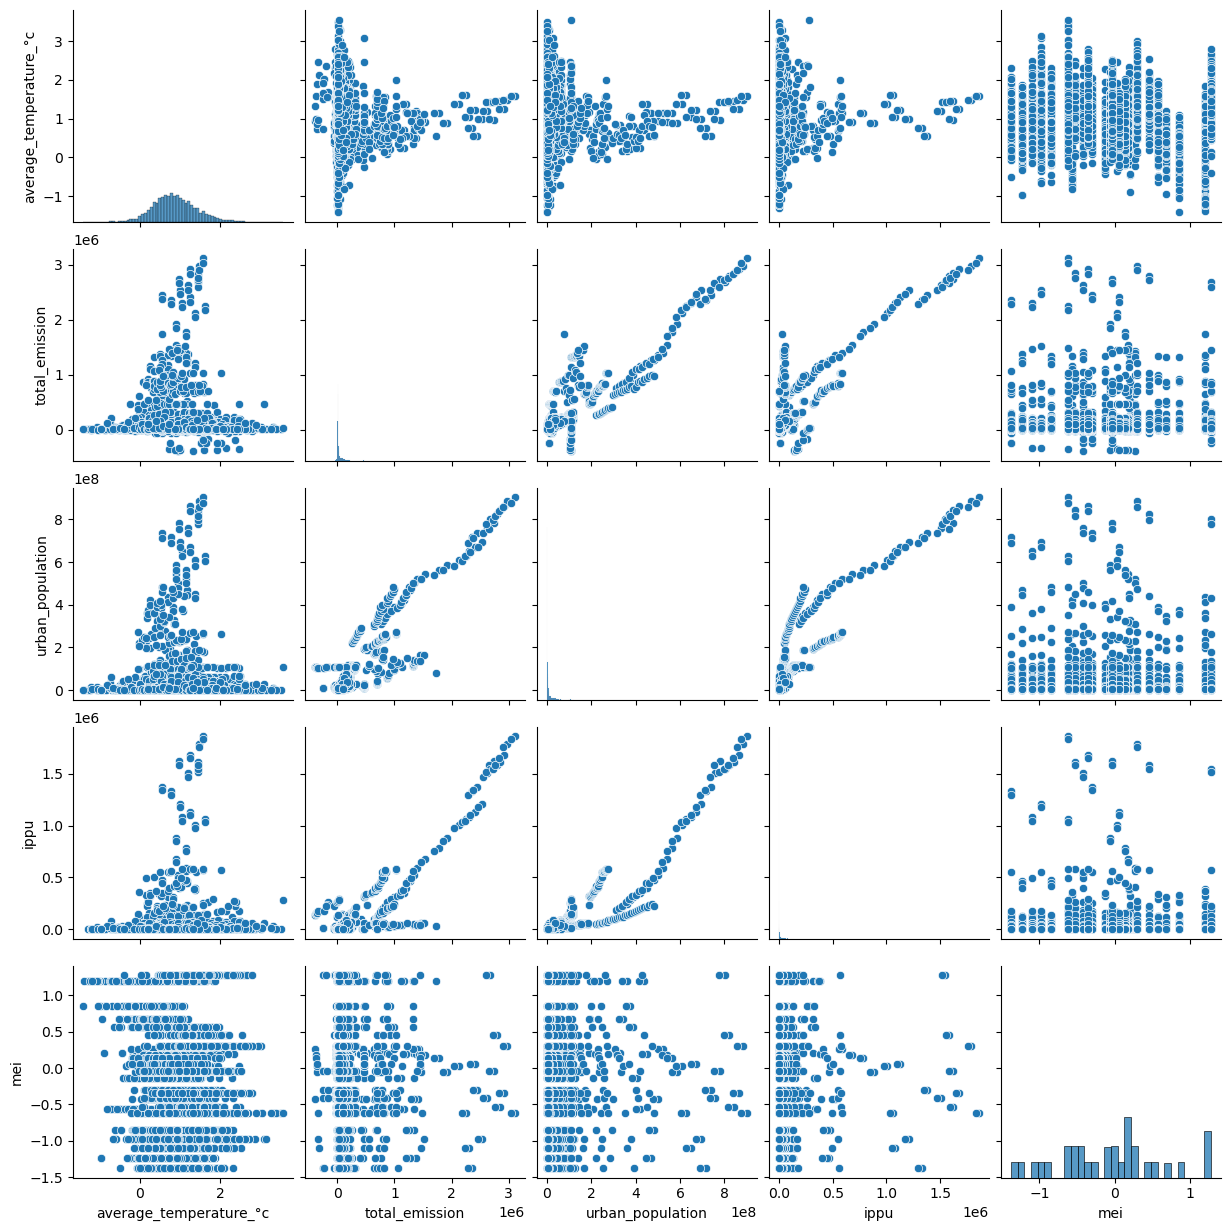

In [94]:
variables = ["average_temperature_°c", "total_emission", "urban_population",'ippu', 'mei']

# scatterplotmatrix(
#     ag_data[variables].values,
#     names=variables,
#     figsize=(18,18), alpha=1
# );

#Print correlation matrix
# print(ag_data[variables].corr())

#Print correlation matrix plots
sns.pairplot(ag_data[variables])

### Summary Statistics

In [6]:
#aggregate data by year to find global emmissions

aggregated_data = ag_data.groupby("year").agg({"average_temperature_°c": "mean", "total_emission": "sum", "urban_population": "sum", 'savanna_fires':'sum', 'forest_fires':'sum', 'crop_residues':'sum',
                                               'rice_cultivation':'sum', 'drained_organic_soils_co2':'sum', 'pesticides_manufacturing':'sum', 'food_transport':'sum', 'forestland':'sum', 'net_forest_conversion':'sum',
                                               'food_household_consumption':'sum', 'food_retail':'sum', 'on-farm_electricity_use':'sum', 'food_packaging':'sum', 'agrifood_systems_waste_disposal':'sum',
                                               'food_processing': 'sum', 'fertilizers_manufacturing':'sum', 'ippu':'sum', 'manure_applied_to_soils':'sum', 'manure_left_on_pasture':'sum', 'manure_management':'sum',
                                               'fires_in_organic_soils':'sum', 'fires_in_humid_tropical_forests':'sum','on-farm_energy_use':'sum'})

In [8]:
aggregated_data.head()

,average_temperature_°c,total_emission,urban_population,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,...,agrifood_systems_waste_disposal,food_processing,fertilizers_manufacturing,ippu,manure_applied_to_soils,manure_left_on_pasture,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use
year,,,,,,,,,,,,,,,,,,,,,
1990,0.582551,1.108960e+07,2.582473e+09,265533.1965,203871.7269,153165.9719,929823.919130,752445.9744,55011.031460,317837.864552,...,1.127063e+06,692307.895096,557482.164606,1.922974e+06,176195.1949,682638.395179,432661.4088,264122.169747,146384.394,716803.1878
1991,0.317404,1.127168e+07,2.653685e+09,265533.1965,203871.7269,148557.7382,930480.142397,752445.9744,54433.936841,326979.000938,...,1.151532e+06,714757.812802,564503.720800,1.959441e+06,177126.0585,698464.238073,435483.0648,264122.169747,146384.394,735176.7298
1992,0.280593,1.116467e+07,2.724484e+09,265533.1965,203871.7267,153469.1554,939513.173286,752445.9743,57481.699902,329402.513986,...,1.172248e+06,651289.802597,516099.286025,2.004423e+06,172642.8169,706086.442420,430599.3615,264122.169747,146384.394,559699.0662
1993,0.256079,1.126050e+07,2.795216e+09,265533.1964,203871.7267,151020.0042,924193.393558,752878.5072,57749.542893,331280.768609,...,1.193446e+06,681259.495540,511923.214923,2.074678e+06,172390.2570,707511.778206,430461.6858,264122.169747,146384.394,542039.2030
1994,0.593787,1.149128e+07,2.866154e+09,265533.1964,203871.7267,152670.0648,927782.202763,752547.1299,62186.034696,330295.753344,...,1.212281e+06,673057.214780,528775.329772,2.186140e+06,174131.3186,718543.276194,434603.0759,264122.169747,146384.394,550889.7282


In [9]:
#find top emitters
aggregated_data.apply(lambda x: x.mean(), axis=0).sort_values()

forestland                        -3.722086e+06
average_temperature_°c             8.692484e-01
pesticides_manufacturing           7.491158e+04
fires_in_humid_tropical_forests    1.468440e+05
crop_residues                      1.796383e+05
manure_applied_to_soils            1.797907e+05
forest_fires                       2.037885e+05
savanna_fires                      2.658162e+05
fires_in_organic_soils             2.719306e+05
on-farm_electricity_use            3.654786e+05
food_packaging                     3.726567e+05
food_transport                     4.357802e+05
manure_management                  4.407682e+05
food_retail                        4.590633e+05
on-farm_energy_use                 5.832572e+05
fertilizers_manufacturing          6.820585e+05
drained_organic_soils_co2          7.870964e+05
manure_left_on_pasture             7.904211e+05
food_processing                    8.701137e+05
rice_cultivation                   9.570509e+05
food_household_consumption         1.015

In [10]:
aggregated_data.describe().transpose()[['mean','std','min','max']]

,mean,std,min,max
average_temperature_°c,8.692484e-01,3.390828e-01,2.560792e-01,1.503059e+00
total_emission,1.439986e+07,2.418064e+06,1.108960e+07,1.856436e+07
urban_population,3.804305e+09,8.060087e+08,2.582473e+09,5.202375e+09
savanna_fires,2.658162e+05,3.296599e+04,2.108460e+05,3.397587e+05
forest_fires,2.037885e+05,3.413170e+04,1.205871e+05,3.169562e+05
crop_residues,1.796383e+05,2.506640e+04,1.485577e+05,2.225405e+05
rice_cultivation,9.570509e+05,2.365337e+04,9.154130e+05,9.938250e+05
drained_organic_soils_co2,7.870964e+05,2.761393e+04,7.524460e+05,8.312247e+05
pesticides_manufacturing,7.491158e+04,1.020329e+04,5.443394e+04,8.752579e+04
food_transport,4.357802e+05,8.450283e+04,3.178379e+05,5.622599e+05


### Aggregate and Plot Data:

In [8]:
#Aggregate data by year (average temperature change, total global emissions, total global urban population)
ag_data_yr = ag_data.groupby("year").agg({"average_temperature_°c": "mean", "total_emission": "sum", "urban_population": "sum"})
ag_data_yr = ag_data_yr.iloc[:21]

In [9]:
def standardize_df (df, features):
    """Standardize each column in a dataframe

    Args:
    df: Specified dataframe 
    features: Array of col names 

    Returns:
    standard_df: A copy of original Dataframe with all columns standardized
    """
    #Create empty dataframe
    standard_df = pd.DataFrame()
    
    #Apply standardization function to all columns in dataframe
    i = 0
    for col in features:
        mean = df.mean(axis=0)
        std_dev = df.std(axis=0)
        standard_df[col] = df[col].apply(lambda x: (x-mean[i])/std_dev[i])
        i += 1
    return standard_df

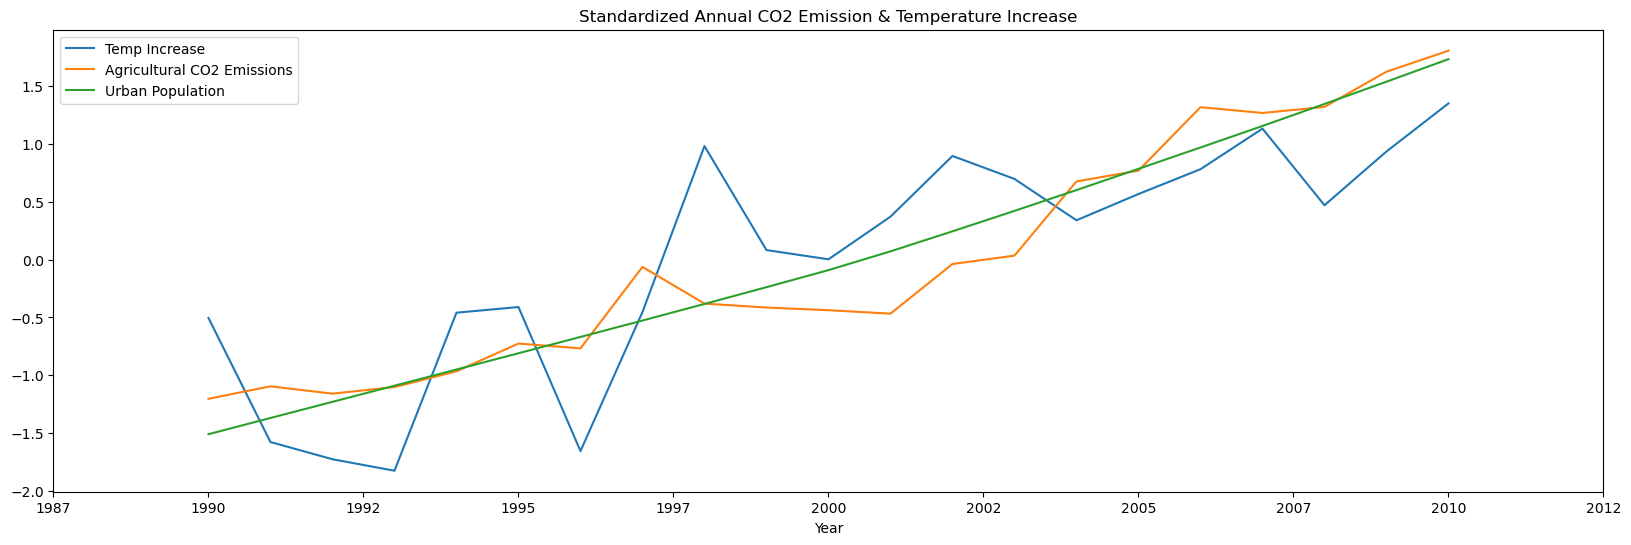

In [10]:
#Apply standard normalization to annual average temperature change, annual total global emissions, annual total urban population)
norm_ag_data_yr = standardize_df(ag_data_yr, ag_data_yr.columns)

norm_ag_data_yr.plot(figsize=(20, 6))
plt.title("Standardized Annual CO2 Emission & Temperature Increase")
plt.xlabel("Year")
plt.legend(['Temp Increase', 'Agricultural CO2 Emissions', 'Urban Population'])
plt.xticks(ticks=plt.xticks()[0], labels=plt.xticks()[0].astype(int))
plt.show()

### Sort and split data

In [13]:
#Sort values by year and reset indexing
ag_data = ag_data.sort_values(by=['year']).reset_index(drop=True)

In [14]:
ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Yugoslav SFR,Zambia,Zimbabwe
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.000000,0.0000,11.807483,63.1152,-2388.8030,...,0,0,0,0,0,0,0,0,0,0
1,Libya,1990,0.5397,0.0000,28.5588,248.061497,0.0000,83.000000,692.9556,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,Liechtenstein,1990,0.0000,0.0000,NaN,9239.011226,0.0000,11.481085,0.0001,10.7375,...,0,0,0,0,0,0,0,0,0,0
3,Madagascar,1990,2615.7130,659.3090,227.7026,5772.435200,4239.3751,3.000000,55.3162,-1457.7823,...,0,0,0,0,0,0,0,0,0,0
4,Malawi,1990,281.4975,410.4235,100.9752,56.922300,838.0748,2.000000,46.0458,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X = ag_data.drop(labels=['average_temperature_°c'], axis=1)
y = ag_data['average_temperature_°c']

In [16]:
X_train, X_val, X_test = X.iloc[:4876], X.iloc[4876:6269], X.iloc[6269:]
y_train, y_val, y_test = y.iloc[:4876], y.iloc[4876:6269], y.iloc[6269:]

In [17]:
print('X Train Shape:', X_train.shape)
print('y Train Shape:', y_train.shape)

print('X Val Shape:', X_val.shape)
print('y Val Shape:', y_val.shape)

print('X Test Shape:', X_test.shape)
print('y Test Shape:', y_test.shape)

X Train Shape: (4876, 265)
y Train Shape: (4876,)
X Val Shape: (1393, 265)
y Val Shape: (1393,)
X Test Shape: (696, 265)
y Test Shape: (696,)


In [18]:
X_train.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Yugoslav SFR,Zambia,Zimbabwe
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.000000,0.0000,11.807483,63.1152,-2388.8030,...,0,0,0,0,0,0,0,0,0,0
1,Libya,1990,0.5397,0.0000,28.5588,248.061497,0.0000,83.000000,692.9556,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,Liechtenstein,1990,0.0000,0.0000,NaN,9239.011226,0.0000,11.481085,0.0001,10.7375,...,0,0,0,0,0,0,0,0,0,0
3,Madagascar,1990,2615.7130,659.3090,227.7026,5772.435200,4239.3751,3.000000,55.3162,-1457.7823,...,0,0,0,0,0,0,0,0,0,0
4,Malawi,1990,281.4975,410.4235,100.9752,56.922300,838.0748,2.000000,46.0458,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)